# Electrical Resistivity Tomography

Using the ert solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve the corresponding inverse problem.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_ert/pygimli_ert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
# !MINICONDA_PREFIX=/usr/local
# !wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
# !chmod +x $MINICONDA_INSTALLER_SCRIPT
# !./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX
# !conda install -c gimli pygimli -y

# import sys
# _ = (sys.path.append("/usr/local/lib/python3.7/site-packages"))

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

from cofi import BaseProblem, InversionOptions, Inversion

np.random.seed(42)

## 1. Define the problem

We first define the true model, the survey and map it on a computational mesh designed for the survey and true anomaly.

Text(0.5, 1.0, 'Resitivity')

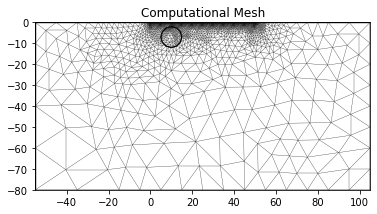

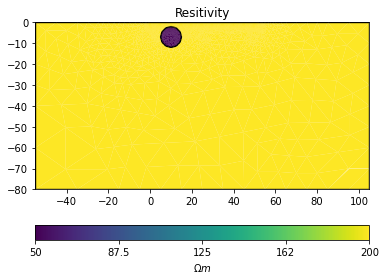

In [3]:
# Generate the survey
scheme = ert.createData(elecs=np.linspace(start=0, stop=50, num=51),schemeName='dd')
# Generate true model
world = mt.createWorld(start=[-55, 0], end=[105, -80], worldMarker=True)
conductive_anomaly = mt.createCircle(pos=[10, -7], radius=5, marker=2)
plc = mt.mergePLC((world, conductive_anomaly))
# Generate forward model mesh
for s in scheme.sensors():
    plc.createNode(s + [0.0, -0.2])
mesh_coarse = mt.createMesh(plc, quality=33)
fmesh = mesh_coarse.createH2()
# link markers to resistivity
rhomap = [[1, 200],
          [2,  50],]
# create model vector
model_true = pg.solver.parseArgToArray(rhomap, fmesh.cellCount(), fmesh)

# plot the compuational mesh and the true model
ax=pg.show(fmesh)
ax[0].set_title("Computational Mesh")
ax=pg.show(fmesh,data=model_true,label=r"$\Omega m$")
ax[0].set_title("Resitivity")

Generate the synthetic data as a container with all the necessary information for plotting.

15/06/22 - 14:29:13 - pyGIMLi - INFO - Calculate geometric factors.


ModellingBase::setMesh() copying new mesh ... Found datafile: 51 electrodes
Found: 51 free-electrodes
rMin = 0.5, rMax = 100
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.038 s
FOP updating mesh dependencies ... 0 s
Obtaining geometric factors (analytical)
Calculating response for model: min = 50 max = 200
Allocating memory for primary potential...... 0.007

No primary potential for secondary field calculation. Calculating analytically...
Factorize (Cholmod) matrix ... 0.017
Factorize (Cholmod) matrix ... 0.014
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.013
Factorize (Cholmod) matrix ... 0.014
Factorize (Cholmod) matrix ... 0.014
Factorize (Cholmod) matrix ... 0.014
Factorize (Cholmod) matrix ... 0.015
Factorize (Cholmod) matrix ... 0.01

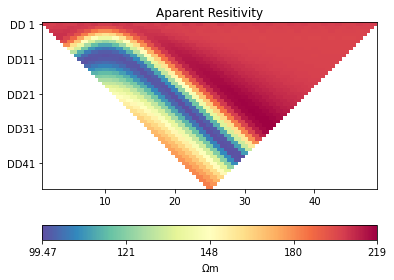

In [4]:
survey = ert.simulate(
        fmesh,
        res=rhomap,
        scheme=scheme,
)
ax=ert.showERTData(survey,label=r"$\Omega$m")
ax[0].set_title("Aparent Resitivity")

y_obs=np.log(survey['rhoa'].array())

The inversion can use a different mesh and the mesh to be used should know nothing about the mesh that was designed based on the true model. Here we first use a triangular mesh for the inversion, which makes the problem underdetermined.

Text(0.5, 1.0, 'Inversion Mesh')

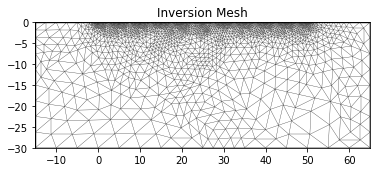

In [5]:
world = mt.createWorld(
    start=[-15, 0], end=[65, -30], worldMarker=False, marker=2)

# local refinement of mesh near electrodes
for s in scheme.sensors():
    world.createNode(s + [0.0, -0.4])

mesh_coarse = mt.createMesh(world, quality=33)
imesh = mesh_coarse.createH2()
for nr, c in enumerate(imesh.cells()):
    c.setMarker(nr)
ax=pg.show(imesh)
ax[0].set_title("Inversion Mesh")

Define the starting model on the inversion mesh.

In [6]:
model_0 = np.ones(imesh.cellCount()) * 80.0

Setup a forward operator with the inversion mesh.

In [7]:
forward_operator = ert.ERTModelling(
    sr=False,
    # verbose=True,
)
forward_operator.setComplex(False)
forward_operator.setData(scheme)
forward_operator.setMesh(imesh, ignoreRegionManager=True)

CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the resiudal with in the case of scipy standardised interfaces.

In [8]:
def get_response(model, y_obs, forward_operator):
    y_synth = np.array(forward_operator.response(model))
    return np.log(y_synth)

def get_jacobian(model, y_obs, forward_operator):
    y_synth_log = get_response(model, y_obs, forward_operator)
    forward_operator.createJacobian(model)
    J0 = np.array(forward_operator.jacobian())
    model_log = np.log(model)
    J = J0 / np.exp(y_synth_log[:, np.newaxis]) * np.exp(model_log)[np.newaxis, :]
    return J

def get_residuals(model, y_obs, forward_operator):
    y_synth_log = get_response(model, y_obs, forward_operator)
    phi = np.abs(np.dot((y_synth_log-y_obs),(y_synth_log-y_obs)))
    return y_synth_log - y_obs

def get_misfit(model, y_obs, forward_operator):
    res = get_residuals(model, y_obs, forward_operator)
    phi = np.abs(np.dot(res, res))
    return phi

Define the regularisation by PyGIMLi.

In [9]:
region_manager = forward_operator.regionManager()
region_manager.setMesh(imesh) 
# region_manager.setVerbose(True)
region_manager.setConstraintType(2)
Wm = pg.matrix.SparseMapMatrix()
region_manager.fillConstraints(Wm)
Wm = pg.utils.sparseMatrix2coo(Wm)

def get_regularisation(model, Wm):
    return np.linalg.norm(Wm.dot(model), 2)

15/06/22 - 14:29:14 - Core - INFO - More than 50 regions, so we assume single regions only.
15/06/22 - 14:29:14 - Core - INFO - Applying *:* interregion constraints.


With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [10]:
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography"
ert_problem.set_forward(get_response, args=[y_obs, forward_operator])
ert_problem.set_jacobian(get_jacobian, args=[y_obs, forward_operator])
ert_problem.set_residual(get_residuals, args=[y_obs, forward_operator])
ert_problem.set_data_misfit(get_misfit, args=[y_obs, forward_operator])
ert_problem.set_regularisation(get_regularisation, lamda=2, args=[Wm])
ert_problem.set_initial_model(model_0)

Review what information is included in the `BaseProblem` object:

In [11]:
ert_problem.summary()

Summary for inversion problem: Electrical Resistivity Tomography
Model shape: (4228,)
---------------------------------------------------------------------
List of functions/properties set by you:
['residual', 'jacobian', 'data_misfit', 'regularisation', 'forward', 'initial_model', 'model_shape']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['objective', 'jacobian_times_vector']
---------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'jacobian_times_vector', 'data', 'data_covariance', 'data_covariance_inv', 'walkers_starting_pos', 'blobs_dtype', 'bounds', 'constraints']


## 2. Define the inversion options

In [12]:
ert_problem.suggest_solvers();

Based on what you've provided so far, here are possible solvers:
{
    "optimisation": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "linear least square": [],
    "sampling": []
}


In [13]:
inv_options = InversionOptions()
inv_options.set_tool("scipy.optimize.minimize")

Review what's been defined for the inversion we are about to run:

In [14]:
inv_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.optimize.minimize` - SciPy's optimisers that minimises a scalar function with respect to one or more variables, check SciPy's documentation page for a list of methods
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


## 3. Start an inversion

In [ ]:
inv = Inversion(ert_problem, inv_options)
inv_result = inv.run()
inv_result.summary()

15/06/22 - 14:29:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/06/22 - 14:29:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


In [ ]:
inv_result.success

## 4. Plotting

In [ ]:
ax=pg.show(
    fmesh,
    data=(model_true),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pg.show(
    imesh,
    data=(model_0),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")


ax=pg.show(
    imesh,
    data=(inv_result.model),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model")

## 5. Rectangular Mesh

Now lets do this on a rectangular mesh in the region of interests for the inversion with boundary represented using triangles.

In [ ]:
imesh=pg.createGrid(x=np.linspace(start=-15, stop=60, num=33),
                                y=np.linspace(start=-30, stop=00, num=15),
                                marker=2)
imesh = pg.meshtools.appendTriangleBoundary(imesh, marker=1,
                                           xbound=50, ybound=50)

for nr, c in enumerate(imesh.cells()):
    c.setMarker(nr)
ax=pg.show(imesh)
ax[0].set_title("Inversion Mesh")

In [ ]:
ax=pg.show(imesh,data=np.linspace(1,imesh.cellCount(),imesh.cellCount()))
ax[0].set_title("Cell indices")

Again, set the starting model value.

In [ ]:
model_0 = np.ones(imesh.cellCount()) * 80.0

Set up the operator and regularisation for the new mesh

In [ ]:
# Forward operator
forward_operator2 = ert.ERTModelling(
    sr=False,
    verbose=True,
)
forward_operator2.setComplex(False)
forward_operator2.setData(scheme)
forward_operator2.setMesh(imesh, ignoreRegionManager=True)
# Regularisation
rm2 = forward_operator2.regionManager()
rm2.setMesh(imesh) 
rm2.setVerbose(True)
rm2.setConstraintType(2)
Wm2 = pg.matrix.SparseMapMatrix()
rm2.fillConstraints(Wm2)
Wm2 = pg.utils.sparseMatrix2coo(Wm2)

Define a new problem instance with the new forward operator.

In [ ]:
ert_problem2 = BaseProblem()
ert_problem2.name = "Electrical Resistivity Tomography"
ert_problem2.set_forward(get_response, args=(y_obs, forward_operator2))
ert_problem2.set_jacobian(get_jacobian, args=(y_obs, forward_operator2))
ert_problem2.set_residual(get_residuals, args=(y_obs, forward_operator2))
ert_problem2.set_data_misfit(get_misfit, args=(y_obs, forward_operator2))
ert_problem2.set_regularisation(get_regularisation, lamda=1, args=(Wm2))
ert_problem2.set_initial_model(model_0)

Run the inversion with the same inversion options.

In [ ]:
inv2 = Inversion(ert_problem2, inv_options)
inv_result2 = inv2.run()
inv_result2.summary()

Plot the results:

In [ ]:
ax=pg.show(
    fmesh,
    data=(model_true),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pg.show(
    imesh,
    data=(model_0),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")

ax=pg.show(
    imesh,
    data=(inv_result2.model),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model")

## 5. Reflections / Conclusion / Further reading

We can see that...

---
## Watermark

In [ ]:
# In case watermark doesn't work (e.g. sphinx-gallery)
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz", "pygimli"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))